In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [16]:
import sys
sys.path.append('..')
from IPython.display import Image
from pysb.simulator import ScipyOdeSimulator, SimulationResult
from pydyno.visualize_simulations import VisualizeSimulations
from pydyno.tools.miscellaneous_analysis import simulate_changing_parameter_in_time
from pydyno.visualize_discretization import visualization_path
from pydyno.util import sig_apop, curve_fit_ftn
# from pydream.convergence import Gelman_Rubin
from apoptosis_model import model as apo_model
from pydyno.discretization import PysbDomPath
from pydyno.seqanalysis import SeqAnalysis
import numpy as np
from time import time
import pandas as pd
from pysb.pattern import SpeciesPatternMatcher, ReactionPatternMatcher, _Reaction
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
import scipy.interpolate
from sklearn import manifold, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
# import umap


%matplotlib inline

# Load sampled parameter vectors from PyDREAM

In [17]:
chain0 = np.load('irvin_calibration/paper_calibration/fluorescence_data_calibration_2020113_0_300000_parameters_ready.npy')
chain1 = np.load('irvin_calibration/paper_calibration/fluorescence_data_calibration_2020113_1_300000_parameters_ready.npy')
# chain2 = np.load('irvin_calibration/paper_calibration/fluorescence_data_calibration_2020113_2_300000_parameters_ready.npy')
chain3 = np.load('irvin_calibration/paper_calibration/fluorescence_data_calibration_2020113_3_300000_parameters_ready.npy')

In [18]:
chain0_logp = np.load('irvin_calibration/paper_calibration/fluorescence_data_calibration_2020113_0_300000_logp_ready.npy')
chain1_logp = np.load('irvin_calibration/paper_calibration/fluorescence_data_calibration_2020113_1_300000_logp_ready.npy')
# chain2_logp = np.load('irvin_calibration/paper_calibration/fluorescence_data_calibration_2020113_2_300000_logp_ready.npy')
chain3_logp = np.load('irvin_calibration/paper_calibration/fluorescence_data_calibration_2020113_3_300000_logp_ready.npy')

# Plot chains' logp values

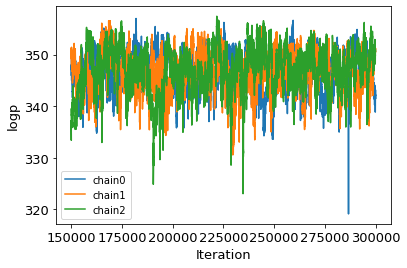

In [9]:
fig_lopg, ax_logp = plt.subplots()
ax_logp.plot(range(150000, 300000), chain0_logp[150000:], label='chain0')
ax_logp.plot(range(150000, 300000), chain1_logp[150000:], label='chain1')
# ax_logp.plot(range(150000, 300000), chain2_logp[150000:], label='chain2')
ax_logp.plot(range(150000, 300000), chain3_logp[150000:], label='chain2')
# plt.ylim(0, 0.5)
plt.legend()

ax_logp.set_xlabel('Iteration')
ax_logp.set_ylabel('logp')
ax_logp.tick_params(axis='both', labelsize=13)
ax_logp.xaxis.label.set_size(13)
ax_logp.yaxis.label.set_size(13)
# ax_logp.ticklabel_format(style='sci',scilimits=(-3,4),axis='x')

fig_lopg.savefig('logp_traces.png', dpi=150, bbox_inches='tight')

# Obtain all parameters

In [19]:
n_likely_pars = 27242 # Number of unique parameter vectors
total_iterations = chain0.shape[0]
iterations_range = range(total_iterations)
# Burnin the first 200k samples
burnin = 200000

# Obtain unique parameter vectors
sampled_log_pars = np.concatenate((chain0[burnin:, :], chain1[burnin:, :], chain3[burnin:, :]))
u, indices, counts = np.unique(sampled_log_pars, return_index=True, 
                               return_counts=True, axis=0)
sorted_counts = np.argsort(counts)[::-1]
most_likely_pars = u[sorted_counts[:n_likely_pars]]
unlog_pars = 10**most_likely_pars

all_pars = np.zeros((n_likely_pars, len(apo_model.parameters)))

In [20]:
u.shape

(27242, 28)

In [21]:
# Obtain indices of kinetic parameters and use them to set the values from the calibrated parameter vectos
# Obtain indices of initial parameters and set the values defined in the model for all the unique parameters
kpar_idxs = []
ic_par_idxs = []
initials_values = []
for i, j in enumerate(apo_model.parameters):
    if j in apo_model.parameters_initial_conditions():
        ic_par_idxs.append(i)
        initials_values.append(j.value)
    else:
        kpar_idxs.append(i)

initials_values = np.array(initials_values)

initials_to_add = np.tile(initials_values, (n_likely_pars, 1))

In [22]:
all_pars[:, kpar_idxs] = unlog_pars
all_pars[:, ic_par_idxs] = initials_to_add

# Figure 1D: Probabilities of parameter sets

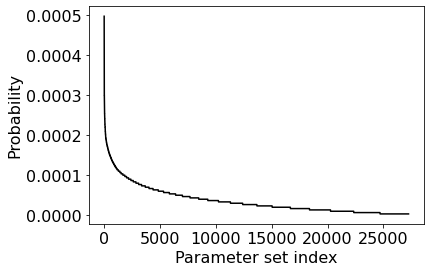

In [39]:
total_samples = np.sum(counts[sorted_counts[:n_likely_pars]])
pctge = counts[sorted_counts[:n_likely_pars]]/total_samples
x_data = range(len(counts[sorted_counts[:n_likely_pars]]))
ax2 = plt.subplot()
ax2.plot(x_data, pctge, color='k')
ax2.set_xlabel('Parameter set index')
ax2.set_ylabel('Probability')
# ax2.tick_params(axis='y', labelcolor='blue')

ax2.tick_params(axis='both', labelsize=16)
ax2.xaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)

plt.savefig('parameter_probabilities.png', dpi=150, bbox_inches='tight')

# ax3 = ax2.twinx()
# ax3.set_ylabel('Cumulative sum', color='red')
# ax3.plot(x_data, np.cumsum(pctge), color='red')
# ax3.tick_params(axis='y', labelcolor='red')


# Figure 1C: Plot distributions of calibrated parameters

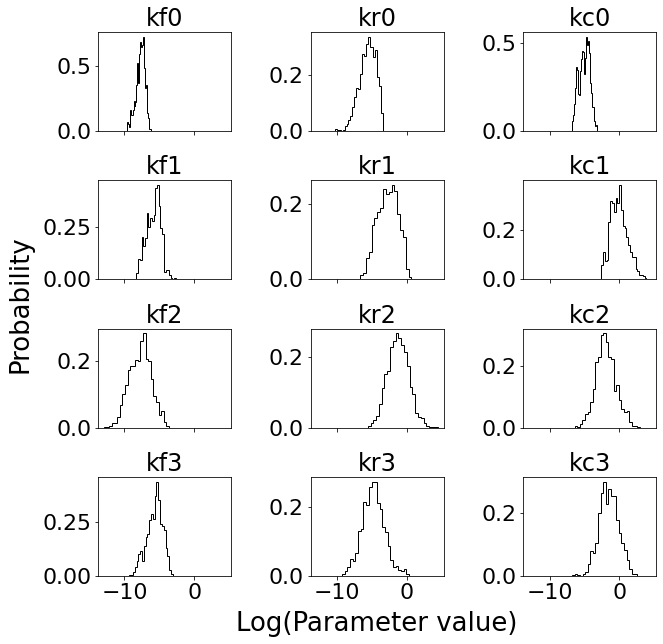

In [559]:
# Indices of parameters related to mBid interactions

rows = 4
columns = 3
counter = 0

f, axes = plt.subplots(rows, columns, figsize=(10, 10), sharex=True)
for r in range(rows):
    for c in range(columns):
        weights = np.ones_like(sampled_log_pars[:, counter])/float(len(sampled_log_pars[:, counter]))
        axes[r, c].hist(sampled_log_pars[:, counter], bins=25, 
                        color='k', density=True, histtype='step')
        axes[r, c].set_title(label=apo_model.parameters[kpar_idxs[counter]].name, fontdict={'fontsize':24})
        axes[r, c].tick_params(axis='both', labelsize=22)
        axes[r, c].xaxis.label.set_size(22)
        axes[r, c].yaxis.label.set_size(22)
        # axes[r, c].set_xlim(-6, 6)
        counter += 1

        if counter >= 12:
            break

# Hide last subplots as nothing is plotted there
# axes[5, 2].axis('off')
            
ax = f.add_subplot(111, frameon=False)
f.subplots_adjust(wspace=0.6)
f.subplots_adjust(hspace=0.5)
# hide tick and tick label of the big axes
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.grid(False)
ax.set_xlabel("Log(Parameter value)", fontsize=26, labelpad=35)
ax.set_ylabel("Probability", fontsize=26, labelpad=65)

f.savefig('parameters_distribution.png', dpi=150, bbox_inches = "tight")

# Supplemental Figure 3: Parameter distributions

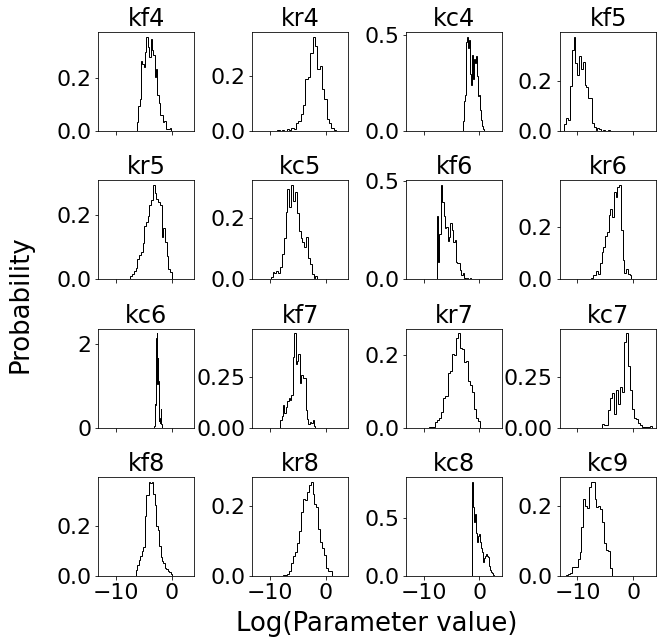

In [38]:
# Indices of parameters related to mBid interactions

rows = 4
columns = 4
counter = 12

f, axes = plt.subplots(rows, columns, figsize=(10, 10), sharex=True)
for r in range(rows):
    for c in range(columns):
        weights = np.ones_like(sampled_log_pars[:, counter])/float(len(sampled_log_pars[:, counter]))
        axes[r, c].hist(sampled_log_pars[:, counter], bins=25, 
                        color='k', density=True, histtype='step')
        axes[r, c].set_title(label=apo_model.parameters[kpar_idxs[counter]].name, fontdict={'fontsize':24})
        axes[r, c].tick_params(axis='both', labelsize=22)
        axes[r, c].xaxis.label.set_size(22)
        axes[r, c].yaxis.label.set_size(22)
        # axes[r, c].set_xlim(-6, 6)
        counter += 1

#         if counter >= 12:
#             break

# Hide last subplots as nothing is plotted there
# axes[5, 2].axis('off')
            
ax = f.add_subplot(111, frameon=False)
f.subplots_adjust(wspace=0.6)
f.subplots_adjust(hspace=0.5)
# hide tick and tick label of the big axes
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.grid(False)
ax.set_xlabel("Log(Parameter value)", fontsize=26, labelpad=35)
ax.set_ylabel("Probability", fontsize=26, labelpad=65)

f.savefig('parameters_distribution_supplement.png', dpi=150, bbox_inches = "tight")

# Gelam Rubin diagnostics

In [25]:
gr = np.loadtxt('irvin_calibration/fluorescence_data_calibration_2020113300000.txt')

In [30]:
par_names = [apo_model.parameters[i].name for i in kpar_idxs]

In [40]:
gr_df = pd.DataFrame(gr[:-6])
gr_df.insert(0, 'Parameter', par_names)
print(gr_df)

   Parameter         0
0        kf0  1.085146
1        kr0  1.002201
2        kc0  1.032267
3        kf1  1.052607
4        kr1  1.005046
5        kc1  1.022576
6        kf2  1.013056
7        kr2  1.003055
8        kc2  1.003935
9        kf3  1.002367
10       kr3  1.005183
11       kc3  1.002087
12       kf4  1.036364
13       kr4  1.009740
14       kc4  1.070748
15       kf5  1.060399
16       kr5  1.111597
17       kc5  1.062530
18       kf6  1.160791
19       kr6  1.019200
20       kc6  1.128064
21       kf7  1.197898
22       kr7  1.015523
23       kc7  1.049738
24       kf8  1.091126
25       kr8  1.001307
26       kc8  1.050739
27       kc9  1.006297


In [ ]:
gr_df.to_csv('aearm_gelman_rubin.csv')

# Prepare parameters file for machine learning analysis

In [ ]:
# Indices of kinetic parameters that define dissociation constants
kd_idxs = [(12, 11), (15, 14), (18, 17), (21, 20), (24, 23), (27, 26), (30, 29),
           (33, 32), (36, 35)]
kd_idxs_len = len(kd_idxs)
kd_names = [f'kd{idx}' for idx in range(kd_idxs_len)]

kc_idxs = [13, 16, 19, 22, 25, 28, 31, 34, 37, 38]
kc_idxs_len = len(kc_idxs)
kc_names = [f'kc{idx}' for idx in range(kc_idxs_len)]

kd_kc_names = kd_names + kc_names

kd_kc_data = np.empty((len(all_pars), kd_idxs_len + kc_idxs_len))

# Obtaining KD values
for idx in range(kd_idxs_len):
    kd_kc_data[:, idx] = all_pars[:, kd_idxs[idx][0]] / all_pars[:, kd_idxs[idx][1]] 

count = 0
for idx in range(kd_idxs_len, kc_idxs_len + kd_idxs_len):
    kd_kc_data[:, idx] = all_pars[:, kc_idxs[count]]
    count += 1

In [ ]:
# Create pandas dataframe with KD and KC data. Each row is a unique sample from pydream (27242 unique parameter vectors)
pars_for_ml = pd.DataFrame(data=kd_kc_data, columns=kd_kc_names)

In [ ]:
# Add clustering labels to do feature importance
pars_for_ml['cluster_label'] = signs_truncated.labels
pars_for_ml.head()

In [ ]:
pars_for_ml.to_csv('kd_kc_data.csv', index=False)

In [ ]:
# Importing file to test #
# bla = pd.read_csv('kd_kc_data.csv')
# bla.head()

# Load simulation with all parameters (27 242  sims)

In [4]:
### DO NOT CHANGE: CODE TO SIMULATE MODEL ###
# tspan = np.linspace(0, 20000, 501)
# sim_all_pars = ScipyOdeSimulator(apo_model, tspan, verbose=True, compiler='cython').run(param_values=all_pars, num_processors=31)
# sim_all_pars.save('simulations_aearm_unique_parameters_obs.h5', include_obs_exprs=True)
#######

sim_all_pars = SimulationResult.load('simulations_aearm_unique_parameters_obs.h5')

# Visualizing simulated results

# Figure 1B. Simulated trajectories of truncated Bid and Cleaved PARP calibrated to reproduce the experimental data. Red dots and bars indicate the mean and standard deviation of the experimental data and blue lines correspond to the simulated trajectories.

In [104]:
# load experimental data
fret_data = pd.read_csv('../fluorescence_data.csv')
fret_data.head()

,# Time,IC-RP,norm_IC-RP,nrm_var_IC-RP,IMS-RP,IMS-RP step,VAR,EC-RP,norm_EC-RP,nrm_var_EC-RP,Condition
0,3,0.7063,0.0,0.0006,0.0,0,1,0.4451,0.0020,0.0003,Control
1,6,0.7063,0.0,0.0006,0.0,0,1,0.4460,0.0018,0.0003,Control
2,9,0.7063,0.0,0.0006,0.0,0,1,0.4459,0.0015,0.0003,Control
3,12,0.7063,0.0,0.0006,0.0,0,1,0.4458,0.0051,0.0003,Control
4,15,0.7063,0.0,0.0006,0.0,0,1,0.4474,0.0038,0.0002,Control


### Visualize tBid dynamics

In [32]:
vs_unclustered = VisualizeSimulations(apo_model, sim_all_pars, clusters=None)

100%|██████████| 27242/27242 [19:02<00:00, 23.85it/s] 


{'comp0_cluster0': (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>)}

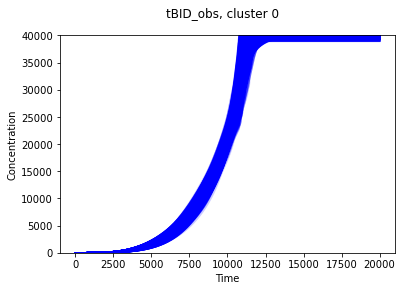

In [33]:
vs_unclustered.plot_cluster_dynamics(['tBID_obs'])

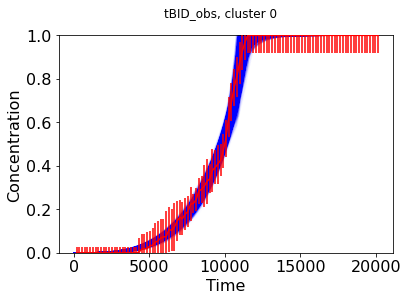

In [581]:
tbid_plot = vs_unclustered.plot_cluster_dynamics(['tBID_obs'], norm=True, 
                                x_data={'tBID_obs': fret_data['# Time']*60}, 
                                y_data={'tBID_obs': fret_data['norm_IC-RP']}, 
                                y_error={'tBID_obs': fret_data['nrm_var_IC-RP']** 0.5})

In [582]:
# Add legend to tBid figure

blue_patch = mpatches.Patch(color='blue', label='tBid sim',)
red_line = mlines.Line2D([], [], color='red', marker='.',
                          markersize=15, label='tBid exp. data')
tbid_plot['plot_sptBID_obs_cluster0'][1].legend(handles=[blue_patch, 
                                                         red_line], 
                                                loc=2, fontsize=13)
tbid_plot['plot_sptBID_obs_cluster0'][1].tick_params(axis='both', 
                                                     labelsize=16)
tbid_plot['plot_sptBID_obs_cluster0'][1].xaxis.label.set_size(16)
tbid_plot['plot_sptBID_obs_cluster0'][1].yaxis.label.set_size(16)
tbid_plot['plot_sptBID_obs_cluster0'][0].savefig('tbid_sim_data.png', 
                                                 dpi=150, 
                                                 bbox_inches = "tight")

### Visualize cPARP dynamics

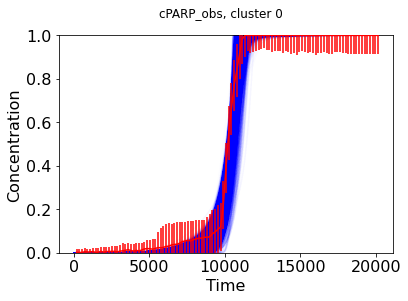

In [585]:
cparp_plot = vs_unclustered.plot_cluster_dynamics(['cPARP_obs'], norm=True, 
                                x_data={'cPARP_obs': fret_data['# Time']*60}, 
                                y_data={'cPARP_obs': fret_data['norm_EC-RP']}, 
                                y_error={'cPARP_obs': fret_data['nrm_var_EC-RP']** 0.5})

In [586]:
# Add legend to cPARP figure

blue_patch = mpatches.Patch(color='blue', label='cPARP sim',)
red_line = mlines.Line2D([], [], color='red', marker='.',
                          markersize=15, label='cPARP exp. data')
cparp_plot['plot_spcPARP_obs_cluster0'][1].legend(handles=[blue_patch, 
                                                           red_line], 
                                                  loc=2, fontsize=13)
cparp_plot['plot_spcPARP_obs_cluster0'][1].tick_params(axis='both', 
                                                       labelsize=16)
cparp_plot['plot_spcPARP_obs_cluster0'][1].xaxis.label.set_size(16)
cparp_plot['plot_spcPARP_obs_cluster0'][1].yaxis.label.set_size(16)
cparp_plot['plot_spcPARP_obs_cluster0'][0].savefig('cparp_sim_data.png',
                                                   dpi=150, 
                                                   bbox_inches = "tight")

# Clustering analysis of the obtained dynamic fingerprints

In [5]:
signs_truncated, paths = SeqAnalysis.load('sequences_aearm_depth10_om1_s2_consumption_reorganized_labels.h5')

### DO NOT CHANGE: : code to obtain sequences shown in paper ###
# dp = PysbDomPath(apo_model, sim_all_pars)
# signs_s2_consumption, paths = dp.get_path_signatures('s2', 'consumption', depth=10, dom_om=1, num_processors=120)
# signs_truncated = signs_s2_consumption.truncate_sequences(260)
# signs_truncated.dissimilarity_matrix(num_processors=120)
# signs_truncated.silhouette_score_agglomerative_range(10 ,num_processors=1) # n_clusters best silhouette score: 3
# signs_truncated.agglomerative_clustering(3)

### Reorganizing clustering labels for visualization purposes
# reorganized_labels = np.copy(signs_truncated.labels)
# mask_cluster0 = reorganized_labels == 0
# mask_cluster1 = reorganized_labels == 1
# mask_cluster2 = reorganized_labels == 2
# reorganized_labels[mask_cluster0] = 2
# reorganized_labels[mask_cluster1] = 1
# reorganized_labels[mask_cluster2] = 3
# signs_truncated.labels = reorganized_labels

# signs_truncated.save('sequences_aearm_depth10_om1_s2_consumption_reorganized_labels.h5', dominant_paths=paths)
####################

In [8]:
reorganized_labels = np.copy(signs_truncated.labels)
mask_cluster0 = reorganized_labels == 0
mask_cluster1 = reorganized_labels == 1
mask_cluster2 = reorganized_labels == 2
reorganized_labels[mask_cluster0] = 2
reorganized_labels[mask_cluster1] = 3
reorganized_labels[mask_cluster2] = 1
signs_truncated.labels = reorganized_labels

In [14]:
signs_truncated.save('sequences_aearm_depth10_om1_s2_consumption_reorganized_labels.h5', dominant_paths=paths)

In [12]:
# Change colors to use a color-blind frindly palette
signs_truncated.states_colors = {1: '#000000', 3: '#D81B60', 6: '#FFC107', 9: '#1E88E5', 
                                27: '#FF4A46', 59: '#008941', 62: '#006FA6', 73: '#A30059'}

## Figure 3A. Modes of signal execution in aEARM. A) Plot of the sequences of dominant subnetworks in each cluster. Subnetworks labels are encoded in different colors

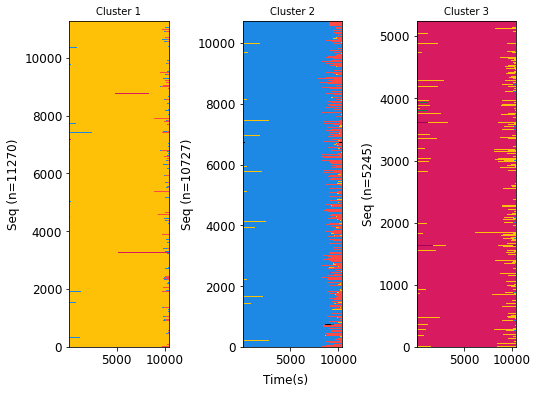

In [13]:
signs_truncated.plot_sequences(type_fig='trajectories')

# Obtain pathways probabilities

In [48]:
pathway1_prob = np.sum(pctge[signs_truncated.labels==1])
pathway2_prob = np.sum(pctge[signs_truncated.labels==2])
pathway3_prob = np.sum(pctge[signs_truncated.labels==3])

print(f'Probability pathway 1: {pathway1_prob}')
print(f'Probability pathway 2: {pathway2_prob}')
print(f'Probability pathway 3: {pathway3_prob}')
print(f'prob total {pathway1_prob+pathway2_prob+pathway3_prob}')

Probability pathway 1: 0.42443333333333333
Probability pathway 2: 0.35583
Probability pathway 3: 0.2197366666666667
prob total 1.0


In [66]:
# Representative sequences from each cluster
reprs = signs_truncated.cluster_representativeness(method='freq')

## Dominant subnetwork in Cluster 1

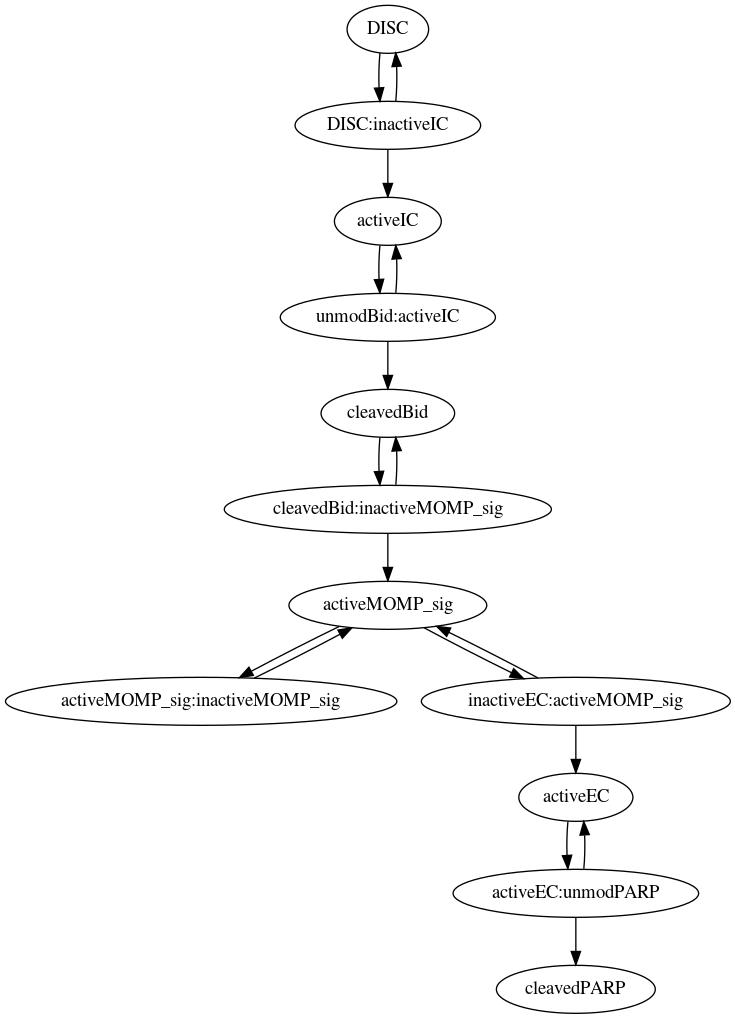

In [123]:
path_label = 6
visualization_path(apo_model, paths[path_label], 'consumption', f'path_{path_label}.png')
Image(filename=f'path_{path_label}.png')

## # Dominant subnetwork in Cluster 2

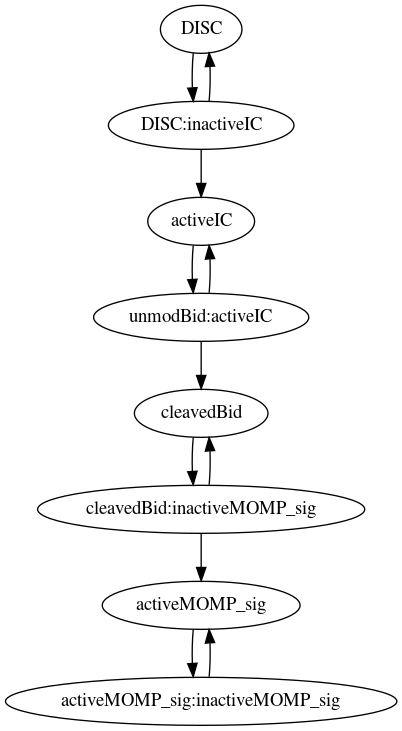

In [120]:
path_label = 9
visualization_path(apo_model, paths[path_label], 'consumption', f'path_{path_label}.png')
Image(filename=f'path_{path_label}.png')

## Dominant subnetwork in Cluster 3

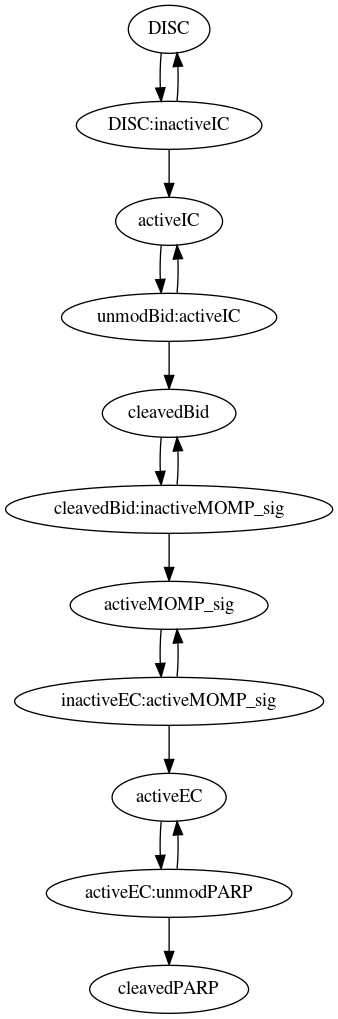

In [122]:
path_label = 3
visualization_path(apo_model, paths[path_label], 'consumption', f'path_{path_label}.png')
Image(filename=f'path_{path_label}.png')

## Figure 3C. Proportion of species related to MOMP activated (MOMP*) relative to the sum total concentration

In [6]:
vs_clusters = VisualizeSimulations(apo_model, sim_all_pars, clusters=signs_truncated.labels)

In [9]:
activated_momp = apo_model.monomers[6](state='active')
sps_avg_clusters = vs_clusters.plot_pattern_sps_distribution(activated_momp, fig_name='momp_wt')

In [45]:
momp_ec_max_clus0 = np.mean(sps_avg_clusters[1][1][1:][:255])
momp_ec_max_clus1 = np.mean(sps_avg_clusters[0][1][1:][:255])
print(momp_ec_max_clus0*100)
print(momp_ec_max_clus1*100)

relative_change_me = (momp_ec_max_clus1 - momp_ec_max_clus0) * 100 / momp_ec_max_clus0
print(relative_change_me)

85.0225577566596
71.9627673781637
-15.36038284789538


# In silico experiment KD of inactive eCaspase

## Figure 4A. Wild type trajectories of cPARP

{'comp0_cluster1': (<Figure size 288x288 with 2 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>),
 'comp0_cluster2': (<Figure size 288x288 with 2 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>),
 'comp0_cluster3': (<Figure size 288x288 with 2 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>)}

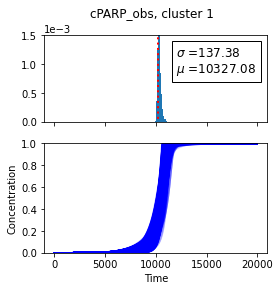

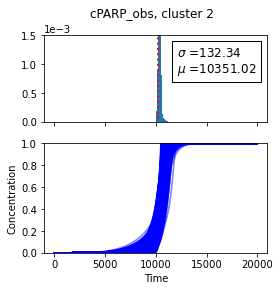

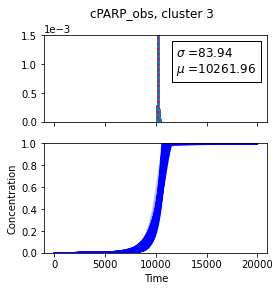

In [62]:
vs_clusters.plot_cluster_dynamics(['cPARP_obs'], species_ftn_fit={'cPARP_obs':sig_apop},
                                  norm=True, fit_options={'p0':[100,100,100]}, plot_format='png', 
                                  figure_options={'figsize':[4,4]})

## Figure 4A. Unclustered WT trajectories

{'comp0_cluster0': (<Figure size 288x288 with 2 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>)}

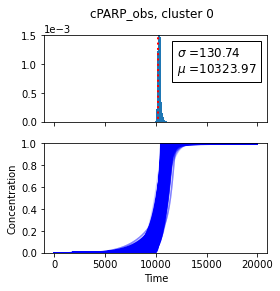

In [64]:
vs_unclustered.plot_cluster_dynamics(['cPARP_obs'], species_ftn_fit={'cPARP_obs':sig_apop},
                                  norm=True, fit_options={'p0':[100,100,100]}, plot_format='png', 
                                  figure_options={'figsize':[4,4]}, fig_name='unclustered')

## Figure 4A. 50% Effector Caspase Knock Down trajectories of cPARP

In [24]:
#### DO NOT CHANGE: CODE TO SIMULATE 50% EFFECTOR CASPASE KNOCK DOWN IN AEARM ####
# import copy
# all_pars_ec_kd = copy.deepcopy(all_pars)
# all_pars_ec_kd[:, 4] = all_pars_ec_kd[:, 4] / 2

# tspan = np.linspace(0, 20000, 501)

# sim_ec_kd = ScipyOdeSimulator(apo_model, tspan, verbose=True, 
#                         compiler='cython').run(param_values=all_pars_ec_kd, 
#                                                num_processors=115, timeout=200)
# sim_ec_kd.save('sim_aearm_ec_50kd.h5')
####

sim_ec_kd = SimulationResult.load('sim_aearm_ec_50kd.h5')


2021-01-21 17:10:23.345 - pysb.simulator.scipyode - DEBUG - [apoptosis_model] Simulator created
2021-01-21 17:10:24.548 - pysb.simulator.scipyode - INFO - [apoptosis_model] Simulation(s) started
2021-01-21 17:10:25.865 - pysb.simulator.scipyode - DEBUG - [apoptosis_model] Multi-processor (parallel) mode using 115 processes
100%|█████████▉| 27221/27242 [04:13<00:00, 142.61it/s]2021-01-21 17:14:46.972 - pysb.simulator.scipyode - INFO - [apoptosis_model] All simulation(s) complete
2021-01-21 17:14:46.978 - pysb.simulator.scipyode - DEBUG - [apoptosis_model] SimulationResult constructor started
100%|██████████| 27242/27242 [04:30<00:00, 142.61it/s]2021-01-21 17:14:56.741 - pysb.simulator.scipyode - DEBUG - [apoptosis_model] SimulationResult constructor finished


In [41]:
vs_ec_kd = VisualizeSimulations(apo_model, sim_ec_kd, clusters=signs_truncated.labels)
vs_ec_kd_unclustered = VisualizeSimulations(apo_model, sim_ec_kd, clusters=None)

{'comp0_cluster1': (<Figure size 288x288 with 2 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>),
 'comp0_cluster2': (<Figure size 288x288 with 2 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>),
 'comp0_cluster3': (<Figure size 288x288 with 2 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>)}

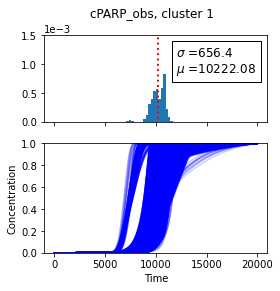

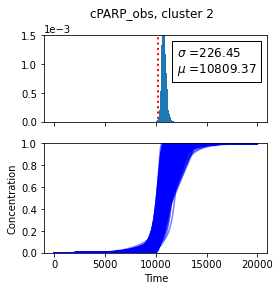

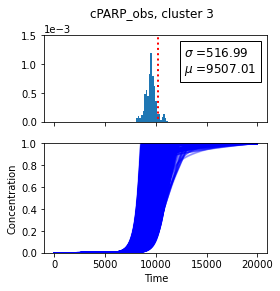

In [42]:
vs_ec_kd.plot_cluster_dynamics(['cPARP_obs'], species_ftn_fit={'cPARP_obs':sig_apop},
                               norm=True, fit_options={'p0':[100,100,100]}, plot_format='png', 
                               figure_options={'figsize':[4,4]})

## Figure 4A. Unclustered trajectories of the 50% Effector Caspase Knock Down

{'comp0_cluster0': (<Figure size 288x288 with 2 Axes>,
  <AxesSubplot:xlabel='Time', ylabel='Concentration'>)}

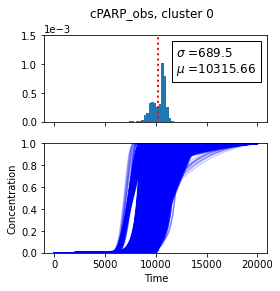

In [69]:
vs_ec_kd_unclustered.plot_cluster_dynamics(['cPARP_obs'], species_ftn_fit={'cPARP_obs':sig_apop},
                                  norm=True, fit_options={'p0':[100,100,100]}, plot_format='png', 
                                  figure_options={'figsize':[4,4]})

## Figure 4A-Right panel: Time to death distributions for each execution mode

### Distributions of time to death in each execution mode

In [72]:
clusters_td = []
clusters_ec_kd = []

for clus in [1, 2, 3]:
    times = []
    times_kd = []
    clus_idxs = np.array(range(27242))[signs_truncated.labels == clus]
    for idx in clus_idxs:
        momp_traj = sim_all_pars.observables[idx]['cPARP_obs']
        ysim_momp_norm = momp_traj / np.nanmax(momp_traj)
        st, sc, sk = scipy.interpolate.splrep(tspan, ysim_momp_norm)
        t10 = scipy.interpolate.sproot((st, sc - 0.10, sk))[0]
        t90 = scipy.interpolate.sproot((st, sc - 0.90, sk))[0]
        td = (t10 + t90) / 2
        times.append(td)
        
        momp_traj_kd = sim_ec_kd.observables[idx]['cPARP_obs']
        ysim_momp_norm_kd = momp_traj_kd / np.nanmax(momp_traj_kd)
        st_kd, sc_kd, sk_kd = scipy.interpolate.splrep(tspan, ysim_momp_norm_kd)
        t10_kd = scipy.interpolate.sproot((st_kd, sc_kd - 0.10, sk_kd))[0]
        t90_kd = scipy.interpolate.sproot((st_kd, sc_kd - 0.90, sk_kd))[0]
        td_kd = (t10_kd + t90_kd) / 2
        times_kd.append(td_kd)
    clusters_td.append(times)
    clusters_ec_kd.append(times_kd)

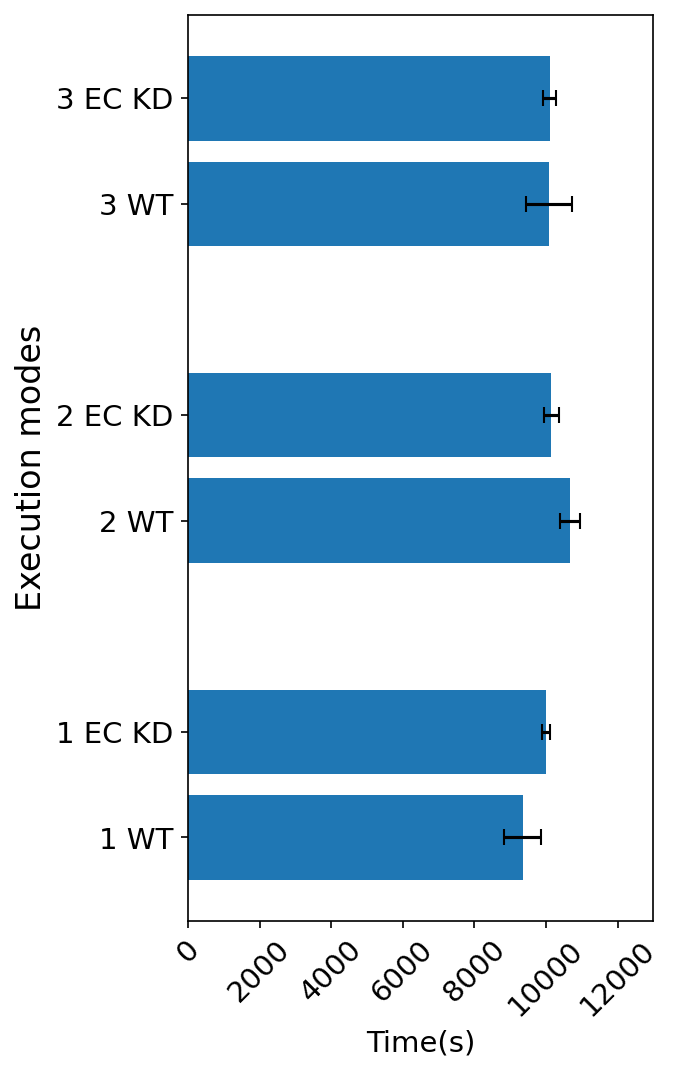

In [73]:
plt.figure(figsize=(4,8), dpi=150)
plt.barh(y=[0, 1, 3, 4, 6, 7], 
         width=[np.mean(clusters_ec_kd[2]), np.mean(clusters_td[2]),
                np.mean(clusters_ec_kd[1]), np.mean(clusters_td[1]),
                np.mean(clusters_ec_kd[0]), np.mean(clusters_td[0])],
        tick_label=['1 WT', '1 EC KD', '2 WT', '2 EC KD', '3 WT', '3 EC KD'],
        xerr=[np.std(clusters_ec_kd[2]), np.std(clusters_td[2]),
              np.std(clusters_ec_kd[1]), np.std(clusters_td[1]),
              np.std(clusters_ec_kd[0]), np.std(clusters_td[0])],
        capsize=4)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.xlabel('Time(s)', fontsize=14)
plt.ylabel('Execution modes', fontsize=16)
plt.xlim(0, 13000)
plt.savefig('barplot_time_death_clusters.png', bbox_inches='tight', dpi=150)

In [74]:
from scipy import stats

s0, p0 = stats.ttest_ind(clusters_ec_kd[0], clusters_td[0])
s1, p1 = stats.ttest_ind(clusters_ec_kd[1], clusters_td[1])
s2, p2 = stats.ttest_ind(clusters_ec_kd[2], clusters_td[2])

print(s0, p0)
print(s1, p1)
print(s2, p2)

-4.876118485875978 1.0893026014704244e-06
150.84604538114144 0.0
-89.6811668777663 0.0


# Analysis of reaction rates to study why clusters respond differently

## Figure 4B. Relative changes in reaction rates due to effector caspase knock down

In [77]:
# Obtain the indices of the dynamic fingerprints present in each cluster
clus0_wt = vs_clusters.clusters[1]
clus1_wt = vs_clusters.clusters[2]
clus2_wt = vs_clusters.clusters[3]

# Use the dynamic fingerprints indices to obtain their respective simulated trajectories
y0_wt = vs_clusters.all_simulations[clus0_wt]
y1_wt = vs_clusters.all_simulations[clus1_wt]
y2_wt = vs_clusters.all_simulations[clus2_wt]

# Use the dynamic fingerprints indices to obtain their respective parameter vectors
pars0_wt = vs_clusters.all_parameters[clus0_wt]
pars1_wt = vs_clusters.all_parameters[clus1_wt]
pars2_wt = vs_clusters.all_parameters[clus2_wt]

# 50% Effector caspase knock down: Obtain simulated trajectories and parameter vectors in each cluster. 
clus0_ec_kd = vs_ec_kd.clusters[1]
clus1_ec_kd = vs_ec_kd.clusters[2]
clus2_ec_kd = vs_ec_kd.clusters[3]

y0_ec_kd = vs_ec_kd.all_simulations[clus0_ec_kd]
y1_ec_kd = vs_ec_kd.all_simulations[clus1_ec_kd]
y2_ec_kd = vs_ec_kd.all_simulations[clus2_ec_kd]

pars0_ec_kd = vs_ec_kd.all_parameters[clus0_ec_kd]
pars1_ec_kd = vs_ec_kd.all_parameters[clus1_ec_kd]
pars2_ec_kd = vs_ec_kd.all_parameters[clus2_ec_kd]

In [93]:
# Use the simulated trajectories to obtain the reaction rate values of 
# MOMP and Effector Caspase activation in each cluster.
# That is 27242 trajectories for each reaction.

momp_reaction = _Reaction(rxn_dict=vs_ec_kd.model.reactions_bidirectional[19], model=vs_ec_kd.model)
momp_reaction_rate = momp_reaction.rate
momp_activation_rate_kd_clus0 = vs_ec_kd._calculate_expr_values(y0_ec_kd, momp_reaction_rate, clus0_ec_kd)
momp_activation_rate_wt_clus0 = vs_clusters._calculate_expr_values(y0_wt, momp_reaction_rate, clus0_wt)
momp_activation_rate_kd_clus1 = vs_ec_kd._calculate_expr_values(y1_ec_kd, momp_reaction_rate, clus1_ec_kd)
momp_activation_rate_wt_clus1 = vs_clusters._calculate_expr_values(y1_wt, momp_reaction_rate, clus1_wt)
momp_activation_rate_kd_clus2 = vs_ec_kd._calculate_expr_values(y2_ec_kd, momp_reaction_rate, clus2_ec_kd)
momp_activation_rate_wt_clus2 = vs_clusters._calculate_expr_values(y2_wt, momp_reaction_rate, clus2_wt)

ec_reaction = _Reaction(rxn_dict=vs_ec_kd.model.reactions_bidirectional[20], model=vs_ec_kd.model)
ec_reaction_rate = ec_reaction.rate
ec_activation_rate_kd_clus0 = vs_ec_kd._calculate_expr_values(y0_ec_kd, ec_reaction_rate, clus0_ec_kd)
ec_activation_rate_wt_clus0 = vs_clusters._calculate_expr_values(y0_wt, ec_reaction_rate, clus0_wt)
ec_activation_rate_kd_clus1 = vs_ec_kd._calculate_expr_values(y1_ec_kd, ec_reaction_rate, clus1_ec_kd)
ec_activation_rate_wt_clus1 = vs_clusters._calculate_expr_values(y1_wt, ec_reaction_rate, clus1_wt)
ec_activation_rate_kd_clus2 = vs_ec_kd._calculate_expr_values(y2_ec_kd, ec_reaction_rate, clus2_ec_kd)
ec_activation_rate_wt_clus2 = vs_clusters._calculate_expr_values(y2_wt, ec_reaction_rate, clus2_wt)

In [98]:
#### cluster 0
# MOMP activation

# Obtain indices where the reaction rate reaches its maximum value (peak)
momp_activation_peaks_idxs_kd_clus0 = np.argmax(momp_activation_rate_kd_clus0[0], 0)
momp_activation_peaks_idxs_wt_clus0 = np.argmax(momp_activation_rate_wt_clus0[0], 0)

# Use the previously obtained indices to get the peak values in each 
# reaction rate trajectory.
momp_activation_peaks_kd_clus0 = np.take_along_axis(momp_activation_rate_kd_clus0[0], 
                                              np.expand_dims(momp_activation_peaks_idxs_kd_clus0, axis=0), axis=0).squeeze(axis=0)
momp_activation_peaks_wt_clus0 = np.take_along_axis(momp_activation_rate_wt_clus0[0], 
                                              np.expand_dims(momp_activation_peaks_idxs_wt_clus0, axis=0), axis=0).squeeze(axis=0)

# Obtain the relative change between the MOMP peak in the wild type condition
# and the MOMP peak in the 50 % effector caspase knock down condition
momp_activation_peaks_diff_clus0 =  (momp_activation_peaks_kd_clus0 - momp_activation_peaks_wt_clus0) / momp_activation_peaks_wt_clus0

# For each reaction rate trajectory, use the previously obtained indices to get 
# the time point where MOMP reaches its peak value.
momp_activativation_peaks_time_kd_clus0 = vs_clusters.tspan[momp_activation_peaks_idxs_kd_clus0]
momp_activativation_peaks_time_wt_clus0 = vs_clusters.tspan[momp_activation_peaks_idxs_wt_clus0]

# Obtain the relative change between the time to reach MOMP peak in the wild type condition
# and the time to reach MOMP peak in the 50 % effector caspase knock down condition
momp_activation_peaks_time_diff_clus0 =  (momp_activativation_peaks_time_kd_clus0 - momp_activativation_peaks_time_wt_clus0) / momp_activativation_peaks_time_wt_clus0

momp_activation_peaks_diff_clus0_avg_std = [np.mean(momp_activation_peaks_diff_clus0), np.std(momp_activation_peaks_diff_clus0)]
momp_activation_peaks_time_diff_clus0_avg_std = [np.mean(momp_activation_peaks_time_diff_clus0), np.std(momp_activation_peaks_time_diff_clus0)]

### Do the same analysis for the effector caspase activation reaction and for each cluster

# EC activation
ec_activation_peaks_idxs_kd_clus0 = np.argmax(ec_activation_rate_kd_clus0[0], 0)
ec_activation_peaks_idxs_wt_clus0 = np.argmax(ec_activation_rate_wt_clus0[0], 0)
ec_activation_peaks_kd_clus0 = np.take_along_axis(ec_activation_rate_kd_clus0[0], 
                                              np.expand_dims(ec_activation_peaks_idxs_kd_clus0, axis=0), axis=0).squeeze(axis=0)
ec_activation_peaks_wt_clus0 = np.take_along_axis(ec_activation_rate_wt_clus0[0], 
                                              np.expand_dims(ec_activation_peaks_idxs_wt_clus0, axis=0), axis=0).squeeze(axis=0)
ec_activation_peaks_diff_clus0 = (ec_activation_peaks_kd_clus0 - ec_activation_peaks_wt_clus0) / ec_activation_peaks_wt_clus0

ec_activativation_peaks_time_kd_clus0 = vs_clusters.tspan[ec_activation_peaks_idxs_kd_clus0]
ec_activativation_peaks_time_wt_clus0 = vs_clusters.tspan[ec_activation_peaks_idxs_wt_clus0]
ec_activation_peaks_time_diff_clus0 =  (ec_activativation_peaks_time_kd_clus0 - ec_activativation_peaks_time_wt_clus0) / ec_activativation_peaks_time_wt_clus0

ec_activation_peaks_diff_clus0_avg_std = [np.mean(ec_activation_peaks_diff_clus0), np.std(ec_activation_peaks_diff_clus0)]
ec_activation_peaks_time_diff_clus0_avg_std = [np.mean(ec_activation_peaks_time_diff_clus0), np.std(ec_activation_peaks_time_diff_clus0)]

#### cluster 1
# MOMP activation
momp_activation_peaks_idxs_kd_clus1 = np.argmax(momp_activation_rate_kd_clus1[0], 0)
momp_activation_peaks_idxs_wt_clus1 = np.argmax(momp_activation_rate_wt_clus1[0], 0)
momp_activation_peaks_kd_clus1 = np.take_along_axis(momp_activation_rate_kd_clus1[0], 
                                              np.expand_dims(momp_activation_peaks_idxs_kd_clus1, axis=0), axis=0).squeeze(axis=0)
momp_activation_peaks_wt_clus1 = np.take_along_axis(momp_activation_rate_wt_clus1[0], 
                                              np.expand_dims(momp_activation_peaks_idxs_wt_clus1, axis=0), axis=0).squeeze(axis=0)
momp_activation_peaks_diff_clus1 = (momp_activation_peaks_kd_clus1 - momp_activation_peaks_wt_clus1) / momp_activation_peaks_wt_clus1

momp_activativation_peaks_time_kd_clus1 = vs_clusters.tspan[momp_activation_peaks_idxs_kd_clus1]
momp_activativation_peaks_time_wt_clus1 = vs_clusters.tspan[momp_activation_peaks_idxs_wt_clus1]
momp_activation_peaks_time_diff_clus1 = (momp_activativation_peaks_time_kd_clus1 - momp_activativation_peaks_time_wt_clus1) / momp_activativation_peaks_time_wt_clus1

momp_activation_peaks_diff_clus1_avg_std = [np.mean(momp_activation_peaks_diff_clus1), np.std(momp_activation_peaks_diff_clus1)]
momp_activation_peaks_time_diff_clus1_avg_std = [np.mean(momp_activation_peaks_time_diff_clus1), np.std(momp_activation_peaks_time_diff_clus1)]

# EC activation
ec_activation_peaks_idxs_kd_clus1 = np.argmax(ec_activation_rate_kd_clus1[0], 0)
ec_activation_peaks_idxs_wt_clus1 = np.argmax(ec_activation_rate_wt_clus1[0], 0)
ec_activation_peaks_kd_clus1 = np.take_along_axis(ec_activation_rate_kd_clus1[0], 
                                              np.expand_dims(ec_activation_peaks_idxs_kd_clus1, axis=0), axis=0).squeeze(axis=0)
ec_activation_peaks_wt_clus1 = np.take_along_axis(ec_activation_rate_wt_clus1[0], 
                                              np.expand_dims(ec_activation_peaks_idxs_wt_clus1, axis=0), axis=0).squeeze(axis=0)
ec_activation_peaks_diff_clus1 = (ec_activation_peaks_kd_clus1 - ec_activation_peaks_wt_clus1) / ec_activation_peaks_wt_clus1

ec_activativation_peaks_time_kd_clus1 = vs_clusters.tspan[ec_activation_peaks_idxs_kd_clus1]
ec_activativation_peaks_time_wt_clus1 = vs_clusters.tspan[ec_activation_peaks_idxs_wt_clus1]
ec_activation_peaks_time_diff_clus1 = (ec_activativation_peaks_time_kd_clus1 - ec_activativation_peaks_time_wt_clus1) / ec_activativation_peaks_time_wt_clus1

ec_activation_peaks_diff_clus1_avg_std = [np.mean(ec_activation_peaks_diff_clus1), np.std(ec_activation_peaks_diff_clus1)]
ec_activation_peaks_time_diff_clus1_avg_std = [np.mean(ec_activation_peaks_time_diff_clus1), np.std(ec_activation_peaks_time_diff_clus1)]

#### cluster 2
# MOMP activation
momp_activation_peaks_idxs_kd_clus2 = np.argmax(momp_activation_rate_kd_clus2[0], 0)
momp_activation_peaks_idxs_wt_clus2 = np.argmax(momp_activation_rate_wt_clus2[0], 0)
momp_activation_peaks_kd_clus2 = np.take_along_axis(momp_activation_rate_kd_clus2[0], 
                                              np.expand_dims(momp_activation_peaks_idxs_kd_clus2, axis=0), axis=0).squeeze(axis=0)
momp_activation_peaks_wt_clus2 = np.take_along_axis(momp_activation_rate_wt_clus2[0], 
                                              np.expand_dims(momp_activation_peaks_idxs_wt_clus2, axis=0), axis=0).squeeze(axis=0)
momp_activation_peaks_diff_clus2 =  (momp_activation_peaks_kd_clus2 - momp_activation_peaks_wt_clus2) / momp_activation_peaks_wt_clus2

momp_activativation_peaks_time_kd_clus2 = vs_clusters.tspan[momp_activation_peaks_idxs_kd_clus2]
momp_activativation_peaks_time_wt_clus2 = vs_clusters.tspan[momp_activation_peaks_idxs_wt_clus2]
momp_activation_peaks_time_diff_clus2 =  (momp_activativation_peaks_time_kd_clus2 - momp_activativation_peaks_time_wt_clus2) / momp_activativation_peaks_time_wt_clus2

momp_activation_peaks_diff_clus2_avg_std = [np.mean(momp_activation_peaks_diff_clus2), np.std(momp_activation_peaks_diff_clus2)]
momp_activation_peaks_time_diff_clus2_avg_std = [np.mean(momp_activation_peaks_time_diff_clus2), np.std(momp_activation_peaks_time_diff_clus2)]

# EC activation
ec_activation_peaks_idxs_kd_clus2 = np.argmax(ec_activation_rate_kd_clus2[0], 0)
ec_activation_peaks_idxs_wt_clus2 = np.argmax(ec_activation_rate_wt_clus2[0], 0)
ec_activation_peaks_kd_clus2 = np.take_along_axis(ec_activation_rate_kd_clus2[0], 
                                              np.expand_dims(ec_activation_peaks_idxs_kd_clus2, axis=0), axis=0).squeeze(axis=0)
ec_activation_peaks_wt_clus2 = np.take_along_axis(ec_activation_rate_wt_clus2[0], 
                                              np.expand_dims(ec_activation_peaks_idxs_wt_clus2, axis=0), axis=0).squeeze(axis=0)
ec_activation_peaks_diff_clus2 = (ec_activation_peaks_kd_clus2 - ec_activation_peaks_wt_clus2) / ec_activation_peaks_wt_clus2

ec_activativation_peaks_time_kd_clus2 = vs_clusters.tspan[ec_activation_peaks_idxs_kd_clus2]
ec_activativation_peaks_time_wt_clus2 = vs_clusters.tspan[ec_activation_peaks_idxs_wt_clus2]
ec_activation_peaks_time_diff_clus2 =  (ec_activativation_peaks_time_kd_clus2 - ec_activativation_peaks_time_wt_clus2) / ec_activativation_peaks_time_wt_clus2

ec_activation_peaks_diff_clus2_avg_std = [np.mean(ec_activation_peaks_diff_clus2), np.std(ec_activation_peaks_diff_clus2)]
ec_activation_peaks_time_diff_clus2_avg_std = [np.mean(ec_activation_peaks_time_diff_clus2), np.std(ec_activation_peaks_time_diff_clus2)]


In [94]:
# Average of reactions
vs_ec_kd_avgs0 = vs_ec_kd._get_avgs(y0_ec_kd, pars0_ec_kd, [momp_reaction, ec_reaction], [], normalize=False)
vs_ec_kd_avgs1 = vs_ec_kd._get_avgs(y1_ec_kd, pars1_ec_kd, [momp_reaction, ec_reaction], [], normalize=False)
vs_ec_kd_avgs2 = vs_ec_kd._get_avgs(y2_ec_kd, pars2_ec_kd, [momp_reaction, ec_reaction], [], normalize=False)

In [95]:
# Average of reactions
vs_wt_avgs0 = vs_clusters._get_avgs(y0_wt, pars0_wt, [momp_reaction, ec_reaction], [], normalize=False)
vs_wt_avgs1 = vs_clusters._get_avgs(y1_wt, pars1_wt, [momp_reaction, ec_reaction], [], normalize=False)
vs_wt_avgs2 = vs_clusters._get_avgs(y2_wt, pars2_wt, [momp_reaction, ec_reaction], [], normalize=False)

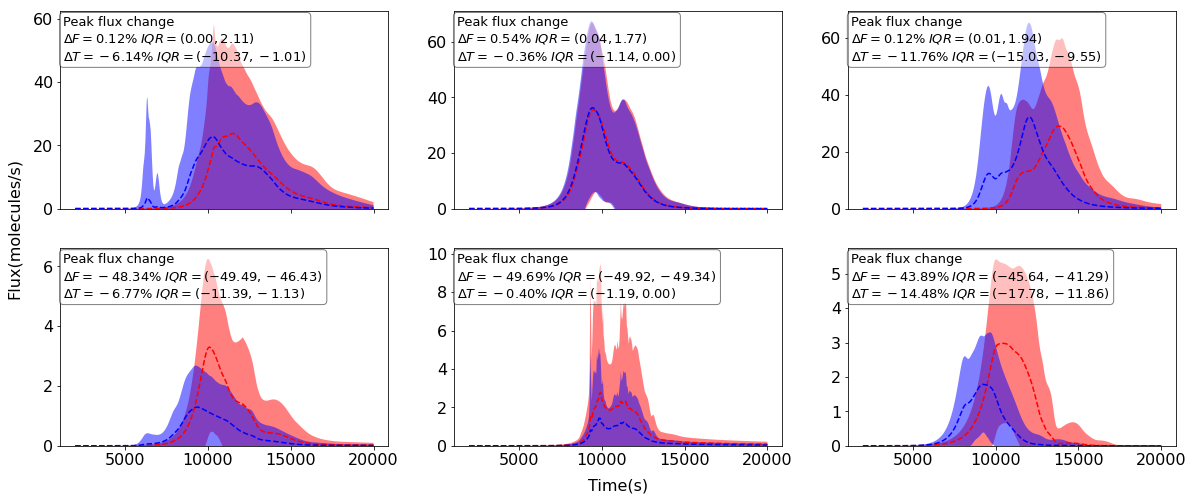

In [99]:
colors = ['red', 'blue']
rxns_idxs = [0, 1] # MOMP reaction, EC reaction
skip = 50

ec_wt_kd_rxns_clusters = ((vs_wt_avgs0, vs_ec_kd_avgs0), (vs_wt_avgs1, vs_ec_kd_avgs1), (vs_wt_avgs2, vs_ec_kd_avgs2))

activation_peaks_clusters = (((momp_activation_peaks_diff_clus0, momp_activation_peaks_time_diff_clus0),
                                     (momp_activation_peaks_diff_clus1, momp_activation_peaks_time_diff_clus1),
                                     (momp_activation_peaks_diff_clus2, momp_activation_peaks_time_diff_clus2)), 
                                     
                                     ((ec_activation_peaks_diff_clus0, ec_activation_peaks_time_diff_clus0),
                                     (ec_activation_peaks_diff_clus1, ec_activation_peaks_time_diff_clus1),
                                     (ec_activation_peaks_diff_clus2, ec_activation_peaks_time_diff_clus2)))

fig, axis_rxns = plt.subplots(2, 3, sharex=True, figsize=(20,8))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

for axis_rows, r_idx, rxn in zip(axis_rxns, rxns_idxs, activation_peaks_clusters):
    for ar, ec_state, rxn_clus in zip(axis_rows, ec_wt_kd_rxns_clusters, rxn):
        # Wild type plot
        ar.plot(vs_ec_kd.tspan[skip:], ec_state[0][0][r_idx][skip:], color='red', linestyle='--', label='WT')
        ar.fill_between(vs_ec_kd.tspan[skip:], ec_state[0][0][r_idx][skip:] + ec_state[0][1][r_idx][skip:], 
                        ec_state[0][0][r_idx][skip:] - ec_state[0][1][r_idx][skip:], facecolor='red', alpha=0.5)
        
        # Knock down plot
        ar.plot(vs_ec_kd.tspan[skip:], ec_state[1][0][r_idx][skip:], color='blue', linestyle='--', label='50% EC KD')
        ar.fill_between(vs_ec_kd.tspan[skip:], ec_state[1][0][r_idx][skip:] + ec_state[1][1][r_idx][skip:],
                        ec_state[1][0][r_idx][skip:] - ec_state[1][1][r_idx][skip:], facecolor='blue', alpha=0.5)
        
        peak_median = np.median(rxn_clus[0])
        peak_q25, peak_q75 = np.percentile(rxn_clus[0], [25 ,75])
        
        peak_time_median = np.median(rxn_clus[1])
        peak_time_q25, peak_time_q75 = np.percentile(rxn_clus[1], [25 ,75])

        momp_txt = '\n'.join(('Peak flux change', 
                              fr"$\Delta F={peak_median*100:.2f} \% \; IQR=({peak_q25*100:.2f}, {peak_q75*100:.2f})$",
                              fr"$\Delta T={peak_time_median*100:.2f} \% \; IQR=({peak_time_q25*100:.2f}, {peak_time_q75*100:.2f})$"))

        ar.text(0.01, 0.975, momp_txt, fontsize=13, verticalalignment='top', bbox=props, transform=ar.transAxes)
        
        ar.set_ylim(bottom=0)
        ar.tick_params(axis='both', labelsize=16)
        ar.xaxis.label.set_size(16)
        ar.yaxis.label.set_size(16)
#         ar.legend(loc=3)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Time(s)", fontsize=16, labelpad=15)
plt.ylabel("Flux(molecules/s)", fontsize=16, labelpad=15)

fig.savefig('momp_ec_rxns_wt_kd.png', dpi=150, bbox_inches='tight')

## Additional analyses to observe changes in the reaction rates of MOMP and Effector Caspase activation due to the 50% Effector caspase knock down

### Changes in the relative amount of MOMP related species in each cluster

In [670]:
vs_ec_kd.plot_pattern_sps_distribution(activated_momp, fig_name='momp_kd')

### Changes in the signal execution modes

In [610]:
dp_ec_kd = PysbDomPath(apo_model, sim_ec_kd)

In [612]:
signs_ec_kd, paths_ec_kd = dp_ec_kd.get_path_signatures('s2', 'consumption', depth=10, dom_om=1, num_processors=100)

In [614]:
signs_ec_kd_truncated = signs_ec_kd.truncate_sequences(260)

In [615]:
signs_ec_kd_truncated.dissimilarity_matrix(num_processors=120)

array([[  0., 520., 520., ...,  18.,   6., 520.],
       [520.,   0.,  12., ..., 518., 520.,  12.],
       [520.,  12.,   0., ..., 518., 520.,   0.],
       ...,
       [ 18., 518., 518., ...,   0.,  24., 518.],
       [  6., 520., 520., ...,  24.,   0., 520.],
       [520.,  12.,   0., ..., 518., 520.,   0.]])

In [671]:
# Use the clustering labels obtain in the discretization of the signal 
# in the wild type condition
signs_ec_kd_truncated.labels = signs_truncated.labels

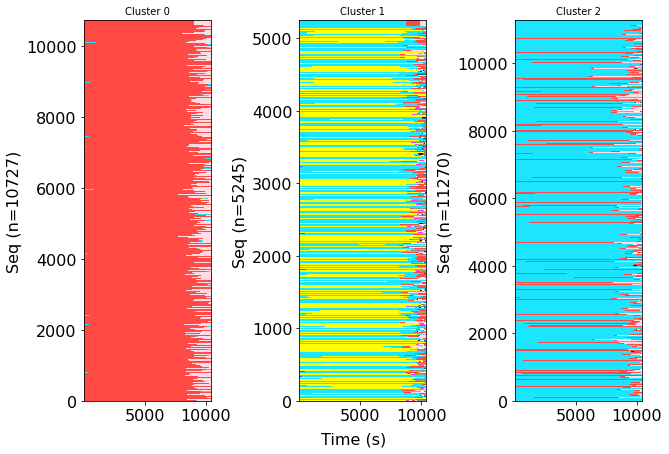

In [672]:
signs_ec_kd_truncated.plot_sequences('trajectories')

In [684]:
reprs_ec_kd = signs_ec_kd_truncated.cluster_representativeness(method='freq')

In [685]:
reprs_ec_kd[1]

,,40.0,80.0,120.0,160.0,200.0,240.0,280.0,320.0,360.0,400.0,...,10040.0,10080.0,10120.0,10160.0,10200.0,10240.0,10280.0,10320.0,10360.0,10400.0
seq_idx,count,,,,,,,,,,,,,,,,,,,,,
4460,1,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


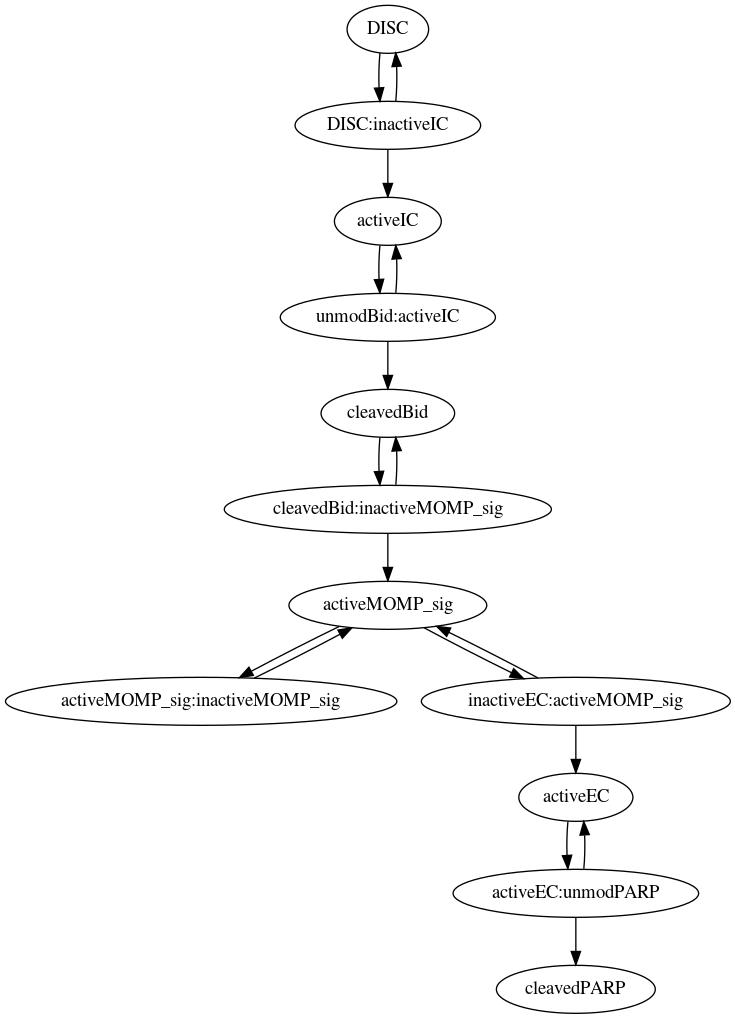

In [678]:
path_label = 6
visualization_path(apo_model, paths_ec_kd[path_label], 'consumption', f'path_kd_{path_label}.png')
Image(filename=f'path_kd_{path_label}.png')

## Figure 5: Reduction of execution mode uncertainty

In [102]:
vs_clusters.plot_violin_pars([26, 29])

In [857]:
from scipy import stats
from scipy.stats import entropy

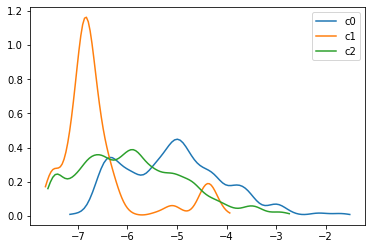

In [863]:
kf6_values0 = sorted(np.log10(sim_all_pars.param_values[signs_truncated.labels==0][:, 26]))
kf6_min0 = np.min(kf6_values0)
kf6_max0 = np.max(kf6_values0)
coords0_kf6 = np.linspace(kf6_min0, kf6_max0, 100)
kf6_kernel0 = stats.gaussian_kde(kf6_values0)

kf6_values1 = sorted(np.log10(sim_all_pars.param_values[signs_truncated.labels==1][:, 26]))
kf6_min1 = np.min(kf6_values1)
kf6_max1 = np.max(kf6_values1)
coords1_kf6 = np.linspace(kf6_min1, kf6_max1, 100)
kf6_kernel1 = stats.gaussian_kde(kf6_values1)

kf6_values2 = sorted(np.log10(sim_all_pars.param_values[signs_truncated.labels==2][:, 26]))
kf6_min2 = np.min(kf6_values2)
kf6_max2 = np.max(kf6_values2)
coords2_kf6 = np.linspace(kf6_min2, kf6_max2, 100)
kf6_kernel2 = stats.gaussian_kde(kf6_values2)

plt.plot(coords0_kf6, kf6_kernel0(coords0_kf6), label='c0')
plt.plot(coords1_kf6, kf6_kernel1(coords1_kf6), label='c1')
plt.plot(coords2_kf6, kf6_kernel2(coords2_kf6), label='c2')
plt.legend()

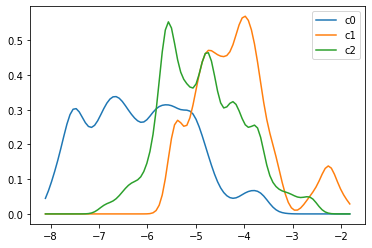

In [1057]:
kf7_values0 = sorted(np.log10(sim_all_pars.param_values[signs_truncated.labels==0][:, 29]))
kf7_min0 = np.min(kf7_values0)
kf7_max0 = np.max(kf7_values0)
coords0_kf7 = np.linspace(kf7_min0, kf7_max0, 100)
kf7_kernel0 = stats.gaussian_kde(kf7_values0)

kf7_values1 = sorted(np.log10(sim_all_pars.param_values[signs_truncated.labels==1][:, 29]))
kf7_min1 = np.min(kf7_values1)
kf7_max1 = np.max(kf7_values1)
coords1_kf7 = np.linspace(kf7_min1, kf7_max1, 100)
kf7_kernel1 = stats.gaussian_kde(kf7_values1)

kf7_values2 = sorted(np.log10(sim_all_pars.param_values[signs_truncated.labels==2][:, 29]))
kf7_min2 = np.min(kf7_values2)
kf7_max2 = np.max(kf7_values2)
coords2_kf7 = np.linspace(kf7_min2, kf7_max2, 100)
kf7_kernel2 = stats.gaussian_kde(kf7_values2)

plt.plot(coords_kf7, kf7_kernel0(coords_kf7), label='c0')
plt.plot(coords_kf7, kf7_kernel1(coords_kf7), label='c1')
plt.plot(coords_kf7, kf7_kernel2(coords_kf7), label='c2')
plt.legend()

In [873]:
def pathway_probability(measurement, pathway_kernel, pathway_prior, 
                        other_kernels, other_priors):
    p = pathway_prior * pathway_kernel(measurement)[0] / \
        (pathway_prior * pathway_kernel(measurement)[0] + 
         other_priors[0] * other_kernels[0](measurement)[0] + 
         other_priors[1] * other_kernels[1](measurement)[0])
    return p

In [1065]:
kf7_max = np.log10(np.max(sim_all_pars.param_values[:, 29]))
kf7_min = np.log10(np.min(sim_all_pars.param_values[:, 29]))
coords_kf7 = np.linspace(kf7_min, kf7_max, 100)

kf6_max = np.log10(np.max(sim_all_pars.param_values[:, 26]))
kf6_min = np.log10(np.min(sim_all_pars.param_values[:, 26]))
coords_kf6 = np.linspace(kf6_min, kf6_max, 100)

initial_entropy=entropy([0.36, 0.42, 0.22], base=2)

kf7_kf6_total_entropy_reduction = []
kf7_kf6_total_measurements_entropies = []

kf7_measurement_entropies = []
kf7_entropy_reduction = []

counter1 = 0
for v in coords_kf7:
    kf6_entropy_reduction = []
    kf6_entropies = []
    p0_kf7=pathway_probability(v, kf7_kernel0, 0.36, [kf7_kernel1, kf7_kernel2], [0.42, 0.22])
    p1_kf7=pathway_probability(v, kf7_kernel1, 0.42, [kf7_kernel0, kf7_kernel2], [0.36, 0.22])
    p2_kf7=pathway_probability(v, kf7_kernel2, 0.22, [kf7_kernel0, kf7_kernel1], [0.36, 0.42])
    kf7_measurement_entropy = entropy([p0_kf7,p1_kf7,p2_kf7], base=2)
    kf7_measurement_entropies.append(kf7_measurement_entropy)
    kf7_entropy_reduction.append(initial_entropy - kf7_measurement_entropy)
    
    for v6 in coords_kf6:
        p0_kf6=pathway_probability(v6, kf6_kernel0, p0_kf7, [kf6_kernel1, kf6_kernel2], [p1_kf7, p2_kf7])
        p1_kf6=pathway_probability(v6, kf6_kernel1, p1_kf7, [kf6_kernel0, kf6_kernel2], [p0_kf7, p2_kf7])
        p2_kf6=pathway_probability(v6, kf6_kernel2, p2_kf7, [kf6_kernel0, kf6_kernel1], [p0_kf7, p1_kf7])
        kf6_measurement_entropy = entropy([p0_kf6, p1_kf6, p2_kf6], base=2)
        kf6_entropies.append(kf6_measurement_entropy)
        kf6_entropy_reduction.append(kf7_measurement_entropy - kf6_measurement_entropy)

    kf7_kf6_total_entropy_reduction.append(kf6_entropy_reduction)
    kf7_kf6_total_measurements_entropies.append(kf6_entropies)

# plt.plot(coords_kf6, entropy_reduction[0])
# plt.plot(coords_kf6, measurements_entropies[0])

# Figure 5D: Execution mode entropy after simulated measurements of kf7

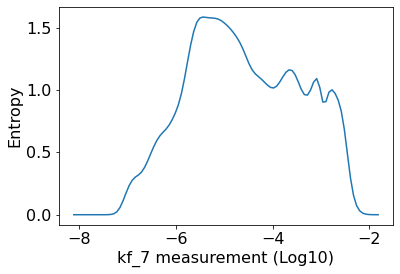

In [1072]:
fig_entropy, ax_entropy = plt.subplots()
ax_entropy.plot(coords_kf7, kf7_measurement_entropies)

ax_entropy.set_xlabel('kf_7 measurement (Log10)')
ax_entropy.set_ylabel('Entropy')

ax_entropy.tick_params(axis='both', labelsize=16)
ax_entropy.xaxis.label.set_size(16)
ax_entropy.yaxis.label.set_size(16)
fig_entropy.savefig('kf7_measurements_entropy', bbox_inches='tight', dpi=150)

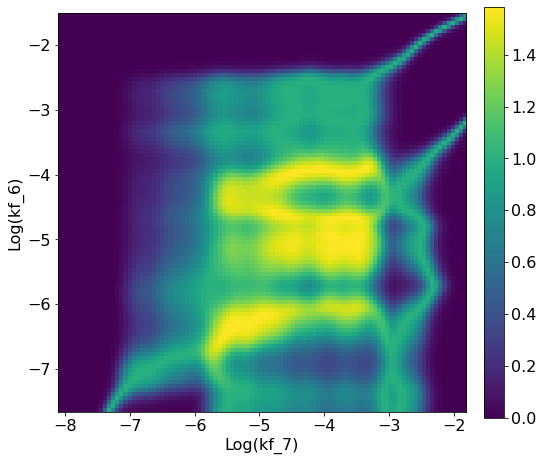

In [1047]:
# Execution mode entropy after simulated measurements of kf6 and kf7

fig_entropy, ax_entropy = plt.subplots(figsize=(8,8))
im = ax_entropy.imshow(np.array(kf7_kf6_total_measurements_entropies).T,
                       extent=[kf7_min, kf7_max, kf6_min, kf6_max],
                       origin='lower')

ax_entropy.set_xlabel('Log(kf_7)')
ax_entropy.set_ylabel('Log(kf_6)')

ax_entropy.tick_params(axis='both', labelsize=16)
ax_entropy.xaxis.label.set_size(16)
ax_entropy.yaxis.label.set_size(16)
cb = fig_entropy.colorbar(im, fraction=0.046, pad=0.04)

cb.ax.tick_params(labelsize=16)

fig_entropy.savefig('entropy_after_measurement.png', bbox_inches='tight', dpi=150)